# 🧠 Model-Based Statistical Process Control (SPC)

In this notebook, we will build a simple **conditional SPC (Statistical Process Control)** system.  
Instead of applying control limits directly to a process variable, we first model its expected value based on contextual conditions — for example, the **cane processing rate** in a sugar mill.

---

### Objectives
1. Simulate a realistic process variable (juice temperature).
2. Fit a regression model that explains normal variation.
3. Compute **residuals** (actual - predicted).
4. Apply SPC on residuals to detect abnormal behavior.
5. Visualize both:
   - Actual vs Predicted Temperature
   - SPC Chart with highlighted anomalies

In [1]:
# ===============================================
# Step 1. Import libraries
# ===============================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Configure matplotlib for better readability
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

## Step 2. Simulate process data

We’ll simulate a scenario similar to what you might find in a sugar mill:
- **`cane_rate`**: tons of cane processed per hour.
- **`temp_jugo`**: juice temperature, which increases slightly with higher cane throughput.

We add some random noise to make the data more realistic.

In [2]:
# ===============================================
# Step 2. Simulate process data
# ===============================================
np.random.seed(42)
n = 200  # number of samples
time = np.arange(n)

# Simulate cane processing rate (ton/h)
cane_rate = 300 + 50*np.sin(time/20) + np.random.normal(0, 5, n)

# Simulate juice temperature (°C)
# Small linear relation + random noise
temp_jugo = 90 + 0.05*cane_rate + np.random.normal(0, 1, n)

df = pd.DataFrame({
    "time": time,
    "cane_rate": cane_rate,
    "temp_jugo": temp_jugo
})

df.head()

,time,cane_rate,temp_jugo
0,0,302.483571,105.481966
1,1,301.807637,105.651166
2,2,308.230114,106.494557
3,3,315.087056,106.808155
4,4,308.762700,104.060466


## Step 3. Fit a linear regression model

We use a simple linear regression to estimate the expected temperature
given the cane processing rate.

The regression equation will be:
$\
\hat{y} = \beta_0 + \beta_1 \times \text{cane_rate}
$

In [3]:
# ===============================================
# Step 3. Fit a linear regression model
# ===============================================
model = LinearRegression()
model.fit(df[["cane_rate"]], df["temp_jugo"])

df["temp_pred"] = model.predict(df[["cane_rate"]])
df["residual"] = df["temp_jugo"] - df["temp_pred"]

intercept = float(model.intercept_)
coef = float(model.coef_[0])

print(f"Model: temp_jugo = {intercept:.3f} + {coef:.5f} * cane_rate")

Model: temp_jugo = 90.390 + 0.04902 * cane_rate


## Step 4. Compute residual statistics and SPC limits

We calculate:
- **Residual mean** (should be near zero)
- **Standard deviation (σ)**
- **Control limits:**  
  $
  \text{UCL} = \bar{e} + 3\sigma, \quad
  \text{LCL} = \bar{e} - 3\sigma
  $

Any point outside these limits indicates an **anomaly**.

In [4]:
# ===============================================
# Step 4. Compute SPC limits on residuals
# ===============================================
mean_res = df["residual"].mean()
std_res = df["residual"].std(ddof=0)
UCL = mean_res + 3 * std_res
LCL = mean_res - 3 * std_res
CL = mean_res

print(f"Residual mean = {mean_res:.4f}, std = {std_res:.4f}")
print(f"LCL = {LCL:.4f}, CL = {CL:.4f}, UCL = {UCL:.4f}")

Residual mean = -0.0000, std = 0.9840
LCL = -2.9519, CL = -0.0000, UCL = 2.9519


## Step 5. Plot actual vs. predicted temperature

This chart shows how well the model follows the observed temperature.

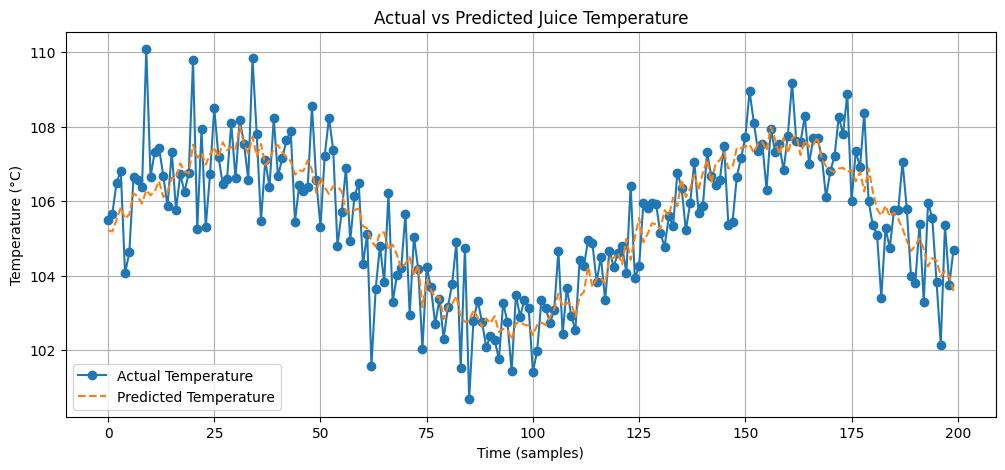

In [5]:
# ===============================================
# Step 5. Plot: Actual vs. Predicted temperature
# ===============================================
plt.figure()
plt.plot(df["time"], df["temp_jugo"], label="Actual Temperature", marker='o', linestyle='-')
plt.plot(df["time"], df["temp_pred"], label="Predicted Temperature", linestyle='--')
plt.title("Actual vs Predicted Juice Temperature")
plt.xlabel("Time (samples)")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.show()

## Step 6. SPC chart on residuals (with anomaly highlighting)

Here we plot the residuals with control limits (±3σ).  
Points outside the limits are marked in **red** as anomalies.

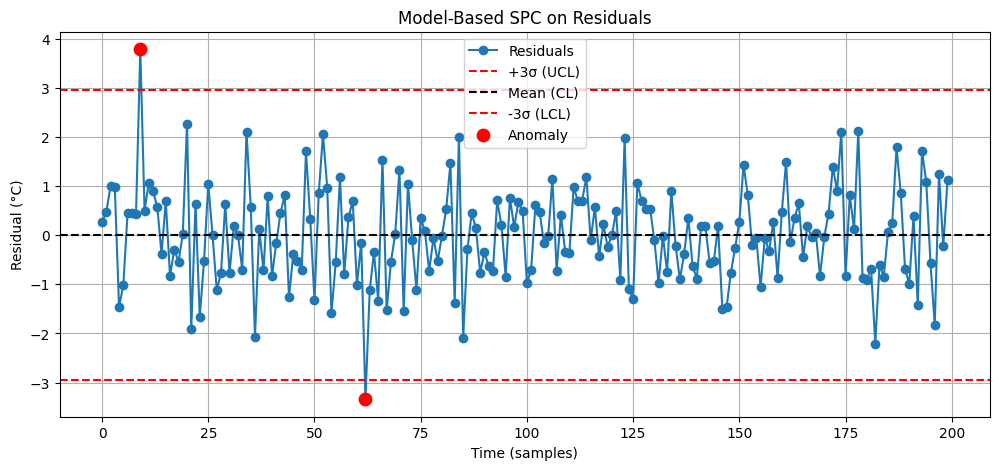

In [6]:
# ===============================================
# Step 6. SPC chart on residuals (with anomalies)
# ===============================================

# Identify anomalies (beyond ±3σ)
df["anomaly"] = (df["residual"] > UCL) | (df["residual"] < LCL)

plt.figure()
plt.plot(df["time"], df["residual"], marker='o', linestyle='-', label="Residuals")
plt.axhline(UCL, color='r', linestyle='--', label="+3σ (UCL)")
plt.axhline(CL, color='k', linestyle='--', label="Mean (CL)")
plt.axhline(LCL, color='r', linestyle='--', label="-3σ (LCL)")

# Highlight anomalies
plt.scatter(df.loc[df["anomaly"], "time"],
            df.loc[df["anomaly"], "residual"],
            color='red', s=80, zorder=3, label="Anomaly")

plt.title("Model-Based SPC on Residuals")
plt.xlabel("Time (samples)")
plt.ylabel("Residual (°C)")
plt.legend()
plt.show()

## ✅ Summary

- The regression model captures the normal trend between `cane_rate` and `temperature`.
- The SPC chart on residuals isolates **true process anomalies**, removing normal contextual effects.
- This approach can be extended easily to:
  - Real plant data (CSV or database)
  - Adaptive rolling σ windows
  - Integration with Grafana for live SPC dashboards